# New File Processor (Observations 13-01-2019)
## For use fits cubes made with quoka from gheald
### By Jack Livingston

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from math import *
import math
import glob
from numpy import unravel_index
import aplpy
from scipy.spatial.distance import pdist, squareform

/pkg/linux/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def floater(textfile):
    """
    Turns text list of frequencies into array
    """
    data=[]
    info=np.asarray(textfile.split('\n'))
    for i in range(len(info)-1):
        data.append(float(info[i]))
    return np.asarray(data)

In [3]:
from numpy import unravel_index
def maxgrabber(datai,dataq,datau,freqinfo):
    """
    Looks at the stokes i data cube and finds the corresponding stokes q and u values for the maximum peak (in stokes i)
    """
    data=[[],[],[],[],[],[],[]] #freq,I,Q,U,rmsI,rmsQ,rmsU
    check=np.median(abs(dataq)) #creates a check for RFI
    c=datai.shape[0] 
    for i in range(c):
        x=unravel_index(datai[i].argmax(), datai[i].shape)[0] #The x pixel that the stokes i max peak is at
        y=unravel_index(datai[i].argmax(), datai[i].shape)[1] #The y pixel that the stokes i max peak is at
        if abs(dataq[i][x,y])<check*75: #checks if the frame is a RFI frequency then puts results into array for use with 
                                        # Cormac's RMsynth and RMclean packages
            data[0].append(floater(freqinfo)[i]) 
            data[1].append(datai[i][x,y])
            data[2].append(dataq[i][x,y])
            data[3].append(datau[i][x,y])
            data[4].append(np.std(datai[i][0:100,0:100])) #Collects Stokes I error
            data[5].append(np.std(dataq[i][0:100,0:100])) #Collects Stokes Q error
            data[6].append(np.std(datau[i][0:100,0:100])) #Collects Stokes U error
    return np.asarray(data)

In [124]:
def extrasource(folder,l,h,a,b):
    """
    Function that allows you to select a height range to look for the stokes i peak (and therefore the stokes q and u info)
    """
    data=[[],[],[],[],[],[],[]] #freq,I,Q,U
    testi=fits.open(folder+'/'+folder.split('/')[-1]+'.i.smooth.fits')[0].data
    testq=fits.open(folder+'/'+folder.split('/')[-1]+'.q.smooth.fits')[0].data
    testu=fits.open(folder+'/'+folder.split('/')[-1]+'.u.smooth.fits')[0].data
    freqinfo=open(folder+'/'+folder.split('/')[-1]+'.i.frequencies.txt','r').read()
    check=np.median(abs(testq))
    c=len(testi)
    position=[[],[]]
    for i in range(c):
        x=(unravel_index(testi[i][l:h,a:b].argmax(), testi[i][l:h,a:b].shape)[0]+l)
        y=(unravel_index(testi[i][l:h,a:b].argmax(), testi[i][l:h,a:b].shape)[1]+a)
        if abs(testq[i][x,y])<check*75:
            data[0].append(floater(freqinfo)[i])
            data[1].append(testi[i][x,y])
            data[2].append(testq[i][x,y])
            data[3].append(testu[i][x,y])
            data[4].append(np.std(testi[i][0:100,0:100]))
            data[5].append(np.std(testi[i][0:100,0:100]))
            data[6].append(np.std(testi[i][0:100,0:100]))
            position[0].append(x)
            position[1].append(y)
    print(np.median(np.asarray(position),axis=1))
    return np.column_stack(np.asarray(data))

In [5]:
def stokescollect(sources):
    return maxgrabber(fits.open(sources+'/'+sources.split('/')[-1]+'.i.smooth.fits')[0].data,
            fits.open(sources+'/'+sources.split('/')[-1]+'.q.smooth.fits')[0].data,
            fits.open(sources+'/'+sources.split('/')[-1]+'.u.smooth.fits')[0].data,
            open(sources+'/'+sources.split('/')[-1]+'.i.frequencies.txt','r').read())

In [41]:
sources=sorted(glob.glob('/priv/myrtle2/possum/livingston/observing0119/data/sources/*'))

In [42]:
sources

['/priv/myrtle2/possum/livingston/observing0119/data/sources/1747-2836',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1756-3122',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1803-2652',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1803-2748',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1803-2947',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1805-2322',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1807-2308',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1809-3025',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1817-2825',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1820-2528',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1820-2910',
 '/priv/myrtle2/possum/livingston/observing0119/data/sources/1823-2726']

In [115]:
alldata=(map(stokescollect,sources))

KeyboardInterrupt: 

In [168]:
for i in range(12):
    savetxt('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/'+ 
        sources[i].split('/')[8] + ".dat" ,column_stack(alldata[i]),delimiter=' ')

In [203]:
savetxt('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/'+ 
        sources[3].split('/')[8] + "_475491" + ".dat" ,extrasource(3,450,490),delimiter=' ')

In [204]:
savetxt('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/'+ 
        sources[8].split('/')[8] + "_502499" + ".dat" ,extrasource(8,479,519),delimiter=' ')

In [250]:
savetxt('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/'+ 
        sources[10].split('/')[8] + "_515500" + ".dat" ,extrasource(10,515,534),delimiter=' ')

In [ ]:
str1='/priv/myrtle2/possum/livingston/observing0119/data/sources/1803-2748'
plt.plot((299792458/extrasource(str1,450,490)[:,0])**2,extrasource(str1,450,490)[:,2],'o')
plt.plot((299792458/extrasource(str1,450,490)[:,0])**2,extrasource(str1,450,490)[:,3],'o')
plt.plot((299792458/alldata[3][0])**2,alldata[3][2],'o')
plt.plot((299792458/alldata[3][0])**2,alldata[3][3],'o')

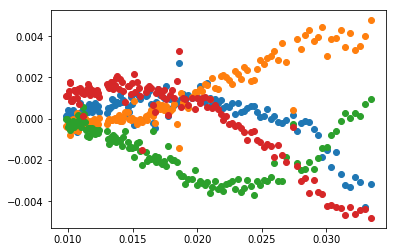

In [199]:
plot((299792458/extrasource(8,479,519)[:,0])**2,extrasource(8,479,519)[:,2],'o')
plot((299792458/extrasource(8,479,519)[:,0])**2,extrasource(8,479,519)[:,3],'o')
plot((299792458/alldata[8][0])**2,alldata[8][2],'o')
plot((299792458/alldata[8][0])**2,alldata[8][3],'o')

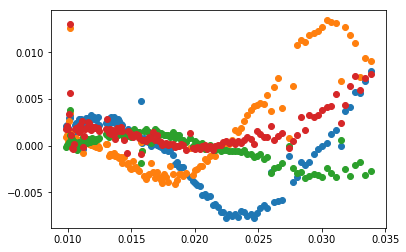

In [251]:
plot((299792458/extrasource(10,515,534)[:,0])**2,extrasource(10,515,534)[:,2],'o')
plot((299792458/extrasource(10,515,534)[:,0])**2,extrasource(10,515,534)[:,3],'o')
plot((299792458/alldata[10][0])**2,alldata[10][2],'o')
plot((299792458/alldata[10][0])**2,alldata[10][3],'o')

In [36]:
np.array([1655.,  567.])

array([1655.,  567.])

In [24]:
data0517_718_1655=extrasource('/priv/myrtle2/possum/livingston/C3086/0517-718',1630,1670)

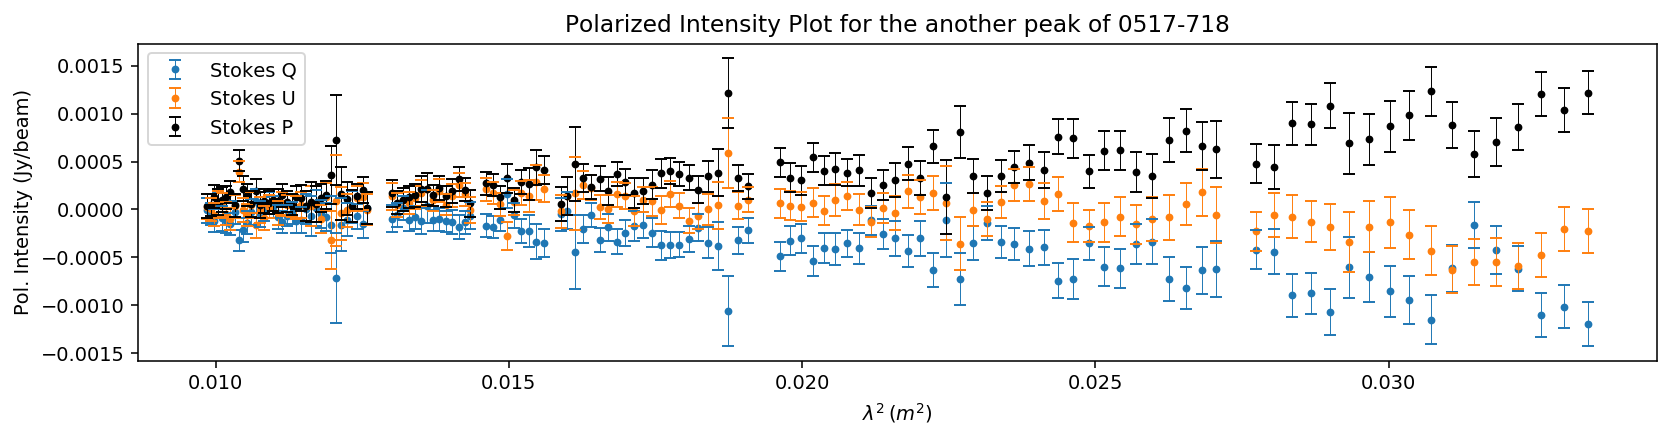

In [25]:
plt.figure(figsize=(14, 3), dpi=140)
plt.errorbar((299792458/data0517_718_1655[:,0])**2,data0517_718_1655[:,2],yerr=data0517_718_1655[:,5],
             color='C0',elinewidth=0.5,ecolor='C0',capsize=3,barsabove=True,label="Stokes Q",fmt='.')
plt.errorbar((299792458/data0517_718_1655[:,0])**2,data0517_718_1655[:,3],yerr=data0517_718_1655[:,6],
             color='C1',elinewidth=0.5,ecolor='C1',capsize=3,barsabove=True,label="Stokes U",fmt='.')
plt.errorbar((299792458/data0517_718_1655[:,0])**2,(data0517_718_1655[:,2]**2+data0517_718_1655[:,3]**2)**0.5,
             yerr=data0517_718_1655[:,6],color='k',elinewidth=0.5,
             ecolor='k',capsize=3,barsabove=True,label="Stokes P",fmt='.')
plt.xlabel(r'$\lambda^2\,(m^{2})$')
plt.ylabel(r'Pol. Intensity (Jy/beam)')
plt.legend()
plt.title('Polarized Intensity Plot for the another peak of 0517-718')
plt.show()

In [37]:
np.savetxt('/priv/myrtle2/possum/livingston/C3086/0517-718/stokesinfo/'+ 
         "0517-718_16550567" + ".dat" ,data0517_718_1655,delimiter=' ')

In [80]:
data0517_718_1075=extrasource('/priv/myrtle2/possum/livingston/C3086/0517-718',1060,1090)

[1075.  318.]


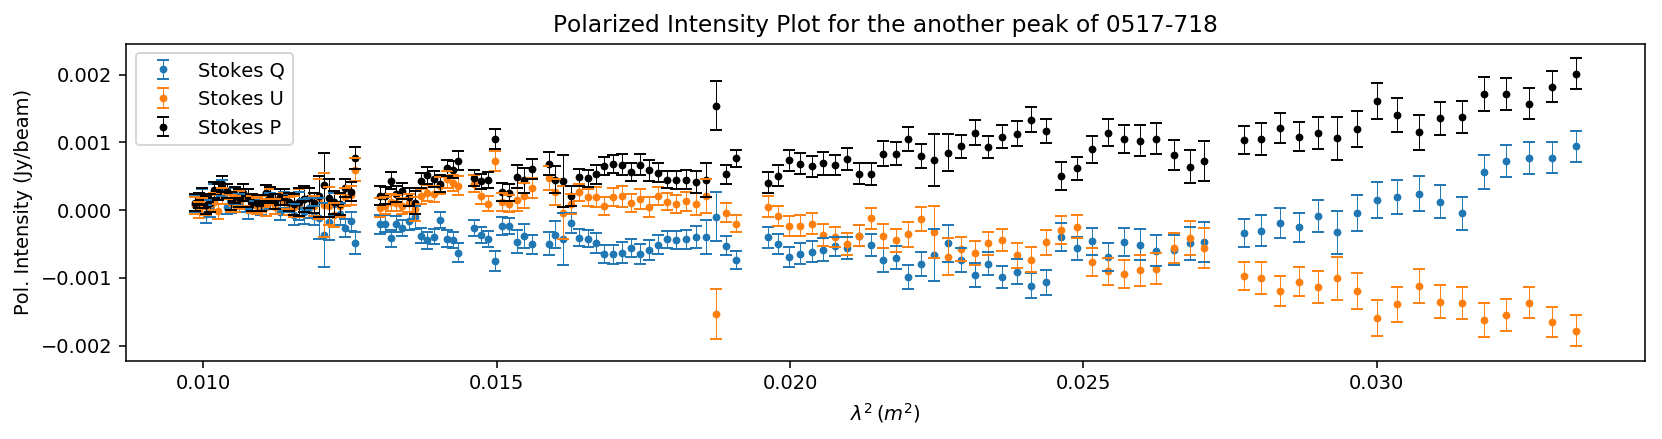

In [81]:
plt.figure(figsize=(14, 3), dpi=140)
plt.errorbar((299792458/data0517_718_1075[:,0])**2,data0517_718_1075[:,2],yerr=data0517_718_1075[:,5],
             color='C0',elinewidth=0.5,ecolor='C0',capsize=3,barsabove=True,label="Stokes Q",fmt='.')
plt.errorbar((299792458/data0517_718_1075[:,0])**2,data0517_718_1075[:,3],yerr=data0517_718_1075[:,6],
             color='C1',elinewidth=0.5,ecolor='C1',capsize=3,barsabove=True,label="Stokes U",fmt='.')
plt.errorbar((299792458/data0517_718_1075[:,0])**2,(data0517_718_1075[:,2]**2+data0517_718_1075[:,3]**2)**0.5,
             yerr=data0517_718_1075[:,6],color='k',elinewidth=0.5,
             ecolor='k',capsize=3,barsabove=True,label="Stokes P",fmt='.')
plt.xlabel(r'$\lambda^2\,(m^{2})$')
plt.ylabel(r'Pol. Intensity (Jy/beam)')
plt.legend()
plt.title('Polarized Intensity Plot for the another peak of 0517-718')
plt.show()

In [82]:
np.savetxt('/priv/myrtle2/possum/livingston/C3086/0517-718/stokesinfo/'+ 
         "0517-718_10750318" + ".dat" ,data0517_718_1075,delimiter=' ')

In [125]:
data0517_718_1030=extrasource('/priv/myrtle2/possum/livingston/C3086/0517-718',1045,1066,200,300)

[1054.  254.]


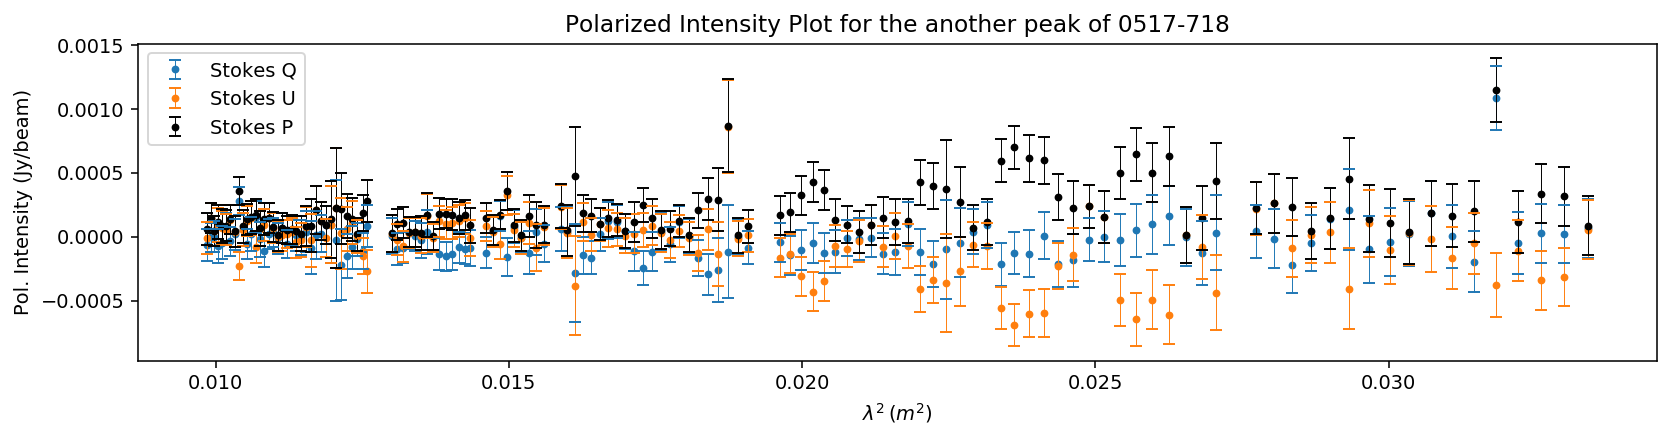

In [126]:
plt.figure(figsize=(14, 3), dpi=140)
plt.errorbar((299792458/data0517_718_1030[:,0])**2,data0517_718_1030[:,2],yerr=data0517_718_1030[:,5],
             color='C0',elinewidth=0.5,ecolor='C0',capsize=3,barsabove=True,label="Stokes Q",fmt='.')
plt.errorbar((299792458/data0517_718_1030[:,0])**2,data0517_718_1030[:,3],yerr=data0517_718_1030[:,6],
             color='C1',elinewidth=0.5,ecolor='C1',capsize=3,barsabove=True,label="Stokes U",fmt='.')
plt.errorbar((299792458/data0517_718_1030[:,0])**2,(data0517_718_1030[:,2]**2+data0517_718_1030[:,3]**2)**0.5,
             yerr=data0517_718_1030[:,6],color='k',elinewidth=0.5,
             ecolor='k',capsize=3,barsabove=True,label="Stokes P",fmt='.')
plt.xlabel(r'$\lambda^2\,(m^{2})$')
plt.ylabel(r'Pol. Intensity (Jy/beam)')
plt.legend()
plt.title('Polarized Intensity Plot for the another peak of 0517-718')
plt.show()

In [142]:
a=fits.open('/priv/myrtle2/possum/livingston/C3086/0517-718/0517-718.q.smooth.fits')[0].data[140]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(a[1045:1066,200:300],cmap='plasma',vmin=-0.001, vmax=0.001);

IndexError: index 140 is out of bounds for axis 0 with size 132

___


## Data Extractor

In [13]:
oldfdmask = np.array([False, False,  True, False,  True, False, False, False, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True,  True, False,  True,  True])

In [14]:
def RMcleannames(PATH):
    filenames=set(glob.glob(PATH+'_RMclean.dat'))
    filenamelist=sorted(list(filenames))
    return filenamelist

In [15]:
def RMsynthnames(PATH):
    filenames=set(glob.glob(PATH+'_RMsynth.dat'))
    filenamelist=sorted(list(filenames))
    return filenamelist

In [16]:
RMcleannames_2015_05_22=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-22/*')
RMsynthnames_2015_05_22=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-22/*')
RMcleannames_2015_05_23=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-23/*')
RMsynthnames_2015_05_23=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-23/*')
RMcleannames_2015_05_24=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-24/*')
RMsynthnames_2015_05_24=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-05-24/*')
RMcleannames_2015_06_08=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-08/*')
RMsynthnames_2015_06_08=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-08/*')
RMcleannames_2015_06_09=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-09/*')
RMsynthnames_2015_06_09=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-09/*')
RMcleannames_2015_06_10=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-10/*')
RMsynthnames_2015_06_10=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-10/*')
RMcleannames_2015_06_11=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-11/*')
RMsynthnames_2015_06_11=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-11/*')
RMcleannames_2015_06_12=RMcleannames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-12/*')
RMsynthnames_2015_06_12=RMsynthnames('/priv/myrtle2/possum/livingston/honoursdata/RMdata/2015-06-12/*')

In [17]:
def PeakFD(Path):
    if (open(Path,'r').read().split('\n')[29].split('=')[1])!='None':
        return float((open(Path,'r').read().split('\n')[29].split('=')[1]))
    if (open(Path,'r').read().split('\n')[29].split('=')[1])=='None':
        return 0.0

In [18]:
def PeakFDerror(Path):
    if (open(Path,'r').read().split('\n')[0].split('=')[1])!='None':
        return float((open(Path,'r').read().split('\n')[0].split('=')[1]))/(np.sqrt(8*np.log(2)))
    if (open(Path,'r').read().split('\n')[0].split('=')[1])=='None':
        return 0.0

In [19]:
def SNRgetter(Path):
    if (open(Path,'r').read().split('\n')[22].split('=')[1])!='None':
        return float((open(Path,'r').read().split('\n')[22].split('=')[1]))
    if (open(Path,'r').read().split('\n')[22].split('=')[1])=='None':
        return 0.0

In [20]:
(open(RMcleannames_2015_05_22[5],'r').read().split('\n')[22].split('=')[1])

'20.6069124362'

In [21]:
phinamesclean=sorted(glob.glob('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/*_RMclean.dat'))[1:15]

In [22]:
phinamessynth=sorted(glob.glob('/priv/myrtle2/possum/livingston/observing0119/data/stokesinfo/*_RMsynth.dat'))[1:15]

In [23]:
fd=asarray(map(PeakFD,phinamesclean))

In [24]:
fderr=asarray(map(PeakFDerror,phinamessynth))/asarray(map(SNRgetter,phinamesclean))

In [25]:
coords = [
    '17h56m22.56s -31d22m15.9s',
    '18h03m19.77s -26d52m14.6s',
    '18h03m17.63s -27d48m35.8s',
    '18h03m16.43s -27d47m53.8s',
    '18h03m56.67s -29d47m16.7s',
    '18h05m42.62s -23d22m44.6s',
    '18h07m15.27s -23d08m44.8s',
    '18h09m53.52s -30d25m21.3s',
    '18h17m26.66s -28d25m07.5s',
    '18h17m22.11s -28d26m07.5s',
    '18h20m57.86s -25d28m13.0s',
    '18h20m40.11s -29d09m50.6s',
    '18h20m40.03s -29d10m12.6s',
    '18h23m20.10s -27d26m31.0s']
c = SkyCoord(coords)
d=column_stack((c.galactic.l.deg,c.galactic.b.deg))

INFO: Auto-setting vmin to  2.379e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.473e+04 [aplpy.core]


/pkg/linux/anaconda2/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


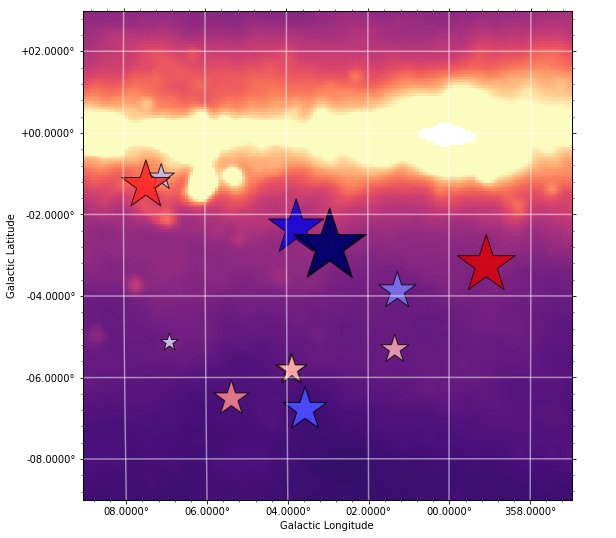

In [26]:
f = aplpy.FITSFigure('/home/jackl/CHIPASS_Gal.fits',dimensions=[0,1],slices=[0, 0])
f.show_colorscale(cmap='magma');
f.recenter(3,-3,radius=6);
f.show_grid();
sc = f.show_markers(d[:,0],d[:,1],s=abs(fd*15),layer='FD', 
               marker='*',c=fd,
               cmap='seismic',alpha=0.8,edgecolor='k',vmin=-400,vmax=400)

___
# Structure Function

In [27]:
def fixx(location):
    """
    Gets angular distance from the GC in l and b 
    where l > 360 is negative (l-360)
    """
    c=len(location)
    data=[[],[]]
    for i in range(c):
        if location[i,0] > 300:  
            data[0].append(location[i,0]-360)
            data[1].append(location[i,1])
        else:
            data[0].append(location[i,0])
            data[1].append(location[i,1])
    return column_stack(asarray(data))

In [28]:
locs=fixx(d)

In [29]:
oldlocations=array([[ 2.43849121,  5.8531367 ],[ 1.65111777,  4.85893974],[ 2.19438121,  4.94287541],
[ 1.99373266,  3.92535351],[ 1.45935052,  3.07709589],[ 1.78641634,  3.13057161],[ 3.8669468 ,  5.8037607 ],
[ 4.23628536,  4.84890371],[ 4.23628536,  4.84890371],[ 4.49803453,  4.967948  ],[ 4.8297703 ,  4.77554371],
[ 8.15535321,  4.76188425],[ 8.41997635,  4.65367999],[ 8.39026708,  4.64705323],[-1.871727  ,  3.25696474],
[-0.55616803,  4.09488564],[-0.274126  ,  4.13742625],[ 0.25741379,  3.83918241],[-1.57087581,  2.51558394],
[ 1.26752601,  2.7465676 ],[ 5.53158964,  2.57943437],[ 5.53527928,  2.57544933],[ 8.08283618,  3.9102143 ],
[ 7.13090952,  3.26412015],[ 7.1301663 ,  3.2708747 ],[ 7.51424117,  2.74427995],[ 6.31965221,  1.97361406],
[ 6.32216711,  1.97454716],[ 6.62915324,  1.38117877],[ 4.97188307,  1.57148431],[ 3.75746332,  0.64352627],
[ 4.90259462,  1.29574241],[ 5.35820197,  0.89959194],[ 5.7902855 ,  0.7940585 ],[ 6.76369857,  0.9223786 ],
[ 6.76662984,  0.9162599 ],[-0.78890026,  1.90293953],[-0.433205  ,  1.14942849],[ 1.04663445,  1.5740484 ],
[ 2.14360931,  1.77262564],[-0.707406  , -0.82003326],[ 8.41997635,  4.65367999],[ 8.39026708,  4.64705323],
[-1.99818001, -0.6363317 ],[-2.128107  , -0.98903395],[-2.532269  , -1.44460724],[-1.84551027, -1.67901348],
[-1.86068437, -1.66999818],[-2.883987  , -2.47295916],[-2.883987  , -2.47295916],[-2.51352212, -2.91526157],
[-2.5180828 , -2.92828519],[ 6.10201216,  5.7455391 ],[ 6.12722447,  5.35781352],[ 6.71679643,  4.96036764],
[ 8.72027155,  5.81317339],[ 9.11335444,  5.24684321],[ 8.41997635,  4.65367999],[ 8.39026708,  4.64705323]])

In [30]:
totallocs=row_stack((oldlocations,locs))

In [31]:
oldfaradaydepths=concatenate((asarray(map(PeakFD,RMcleannames_2015_05_22)),
             asarray(map(PeakFD,RMcleannames_2015_05_23)),
             asarray(map(PeakFD,RMcleannames_2015_05_24)),
             asarray(map(PeakFD,RMcleannames_2015_06_08)),
             asarray(map(PeakFD,RMcleannames_2015_06_09)),
             asarray(map(PeakFD,RMcleannames_2015_06_10)),
             asarray(map(PeakFD,RMcleannames_2015_06_11)),
             asarray(map(PeakFD,RMcleannames_2015_06_12))))*oldfdmask

In [32]:
totalfd=append(oldfaradaydepths,fd)

In [371]:
totalfd.shape

(73,)

In [33]:
oldfderror = (concatenate((asarray(map(PeakFDerror,RMsynthnames_2015_05_22)),
             asarray(map(PeakFDerror,RMsynthnames_2015_05_23)),
             asarray(map(PeakFDerror,RMsynthnames_2015_05_24)),
             asarray(map(PeakFDerror,RMsynthnames_2015_06_08)),
             asarray(map(PeakFDerror,RMsynthnames_2015_06_09)),
             asarray(map(PeakFDerror,RMsynthnames_2015_06_10)),
             asarray(map(PeakFDerror,RMsynthnames_2015_06_11)),
             asarray(map(PeakFDerror,RMsynthnames_2015_06_12))))*oldfdmask/
              concatenate((asarray(map(SNRgetter,RMcleannames_2015_05_22)),
             asarray(map(SNRgetter,RMcleannames_2015_05_23)),
             asarray(map(SNRgetter,RMcleannames_2015_05_24)),
             asarray(map(SNRgetter,RMcleannames_2015_06_08)),
             asarray(map(SNRgetter,RMcleannames_2015_06_09)),
             asarray(map(SNRgetter,RMcleannames_2015_06_10)),
             asarray(map(SNRgetter,RMcleannames_2015_06_11)),
             asarray(map(SNRgetter,RMcleannames_2015_06_12)))))
oldfderror[np.isnan(oldfderror)] = 0

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [455]:
fderr

array([0.48703946, 1.28597753, 1.68603411, 1.01806701, 0.37584649,
       0.21118053, 1.0771698 , 0.32916821, 1.99497444, 0.46389808,
       0.98519428, 0.71166443, 0.82226115, 0.24665972])

In [34]:
totalfderr=append(oldfderror,fderr)

In [465]:
(err)/(np.nanmean(rm_sf, axis=1))

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([[0.99791274, 0.99763342, 0.99789112, 0.99763452, 0.99777904,
        0.99485901, 0.98621725,        nan,        nan,        nan],
       [1.00189278, 1.00236512, 1.00205723, 1.00211734, 1.00226622,
        1.00549619, 1.0134779 ,        nan,        nan,        nan]])

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


(48, 14)


/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in divide


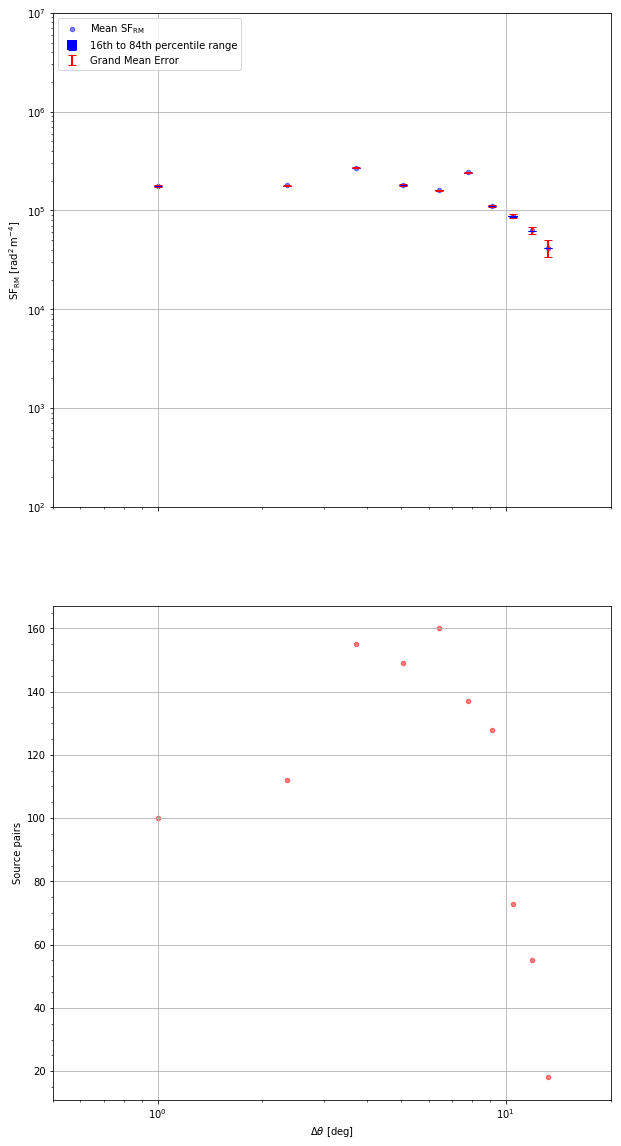

In [508]:
def SF(l,RM,s):
    """
    Calculates the difference in RM or FD, and 
    attaches the distance between the two points
    Input:
    l=locations in (x,y) format of sources in galactic coordinates (where lat > 360 are negative [l-360])
    RM=data you want to take the difference of, just a series of values
    s=The object you want to take the difference of
    
    Output:
    Calculates the difference in RM or FD, and 
    attaches the distance between the two points
    """
    c=len(RM)
    data=[]
    dist=squareform(pdist(l))[s]
    for i in range(c):
        if np.nanmean(RM[s])-np.nanmean(RM[i]) != np.nanmean(RM[s]) and np.nanmean(RM[s])-np.nanmean(RM[i]) != 0.0:
            data.append(((RM[s]-RM[i])**2,dist[i]))
    #print data
    #print np.asarray(data)[0,:]
    return np.asarray(data)

def SFbinner(l, RM, s, bins):
    """
    Puts the SF data for each source into angular separation bins
    Input:
    l=locations in (x,y) format
    RM=data you want to take the difference of, just a series of values
    s=The object you want to take the difference of
    bins = the array of angular separation bins
    """
    info = SF(l,RM,s)
    #print info.shape
    c = len(info)
    data = np.zeros((len(bins),c,1000))
    #data = np.zeros((len(bins),c))
    nums = np.zeros(len(bins)-1)
    for i in range(c):
        for j in range(len(bins)-1):
            if bins[j] < info[i,1] < bins[j+1]:
                #print info[i,0].shape
                data[j,i] = info[i,0]
                nums[j] += 1

    #print np.count_nonzero(data, axis=1)
    #print data.shape
    data[data == 0] = np.nan
    #print data.shape[0]
    #for i in range(data.shape[0]):
    #    dat = data[i,:,0]
    #    print len(dat[~np.isnan(dat)])
    #print len(data[0,:])
    means = np.nanmean(data, axis=1)
    
    #print means.shape
    #print len(data[~np.isnan(data)])
    return means, nums

def finalSF(l, RM, bins):
    '''
    Collects all of the SF data from all sources into bins of angular separation
    Input:
    l=locations in (x,y) format
    RM=data you want to take the difference of, just a series of values
    s=The object you want to take the difference of
    bins = the array of angular separation bins
    '''
    c = len(RM)
    data = []
    numb = []
    for s in range(c):
        if np.nanmean(RM[s]) != 0.0:
            means, nums = SFbinner(l, RM, s, bins)
            data.append(means)
            numb.append(nums)
    data = np.array(data)
    #print data.shape
    numb = np.array(numb)
    print numb.shape
    #nos = []
    #for i in range(data.shape[1]):
    #    dat = np.array(data)[:,i,0]
    #    #dat = np.array(data)[:,i]
    #    nos.append(len(dat[~np.isnan(dat)]))
    #    #print len(dat[~np.isnan(dat)])
    #nos = np.array(nos, dtype=float)
    numb[numb == 0] = np.nan
    numb = np.nansum(numb, axis=0)
    numb[numb == 0] = np.nan
    return np.nanmean(data, axis=0), numb#, nos

## Example usage with logspace (to evenly sample deltatheta in log-space)
start = 1
stop = 20
num = 15

bins = np.log10(np.logspace(start, stop, num, endpoint=True)) # sample from 1e-4 to 1e2, evenly in log space
rm_sf, nums = finalSF(totallocs, rm_dist, bins)

low = np.nanpercentile(rm_sf, 16, axis=1)
high = np.nanpercentile(rm_sf, 84, axis=1)
err = np.array([low.astype(float), high.astype(float)])
fig = plt.figure()
ax = plt.subplot(211)
ax.scatter(bins, np.nanmean(rm_sf, axis=1),color='b', s=20, alpha = 0.5, label =r'Mean SF$_\mathrm{RM}$')

#plt.fill_between(bins, np.nanpercentile(rm_sf, 16, axis=1), np.nanpercentile(rm_sf, 84, axis=1))
ax.errorbar(bins, np.nanmean(rm_sf, axis=1), yerr=(np.nanmean(rm_sf, axis=1)-err), color='b',
            marker=None, fmt=' ', label = '16th to 84th percentile range',
    capsize=4, elinewidth=10)
ax.errorbar(bins, np.nanmean(rm_sf, axis=1), yerr=50000/np.sqrt(append(nan_to_num(nums),0)), color='r',
            marker=None, fmt=' ', label = 'Grand Mean Error',
    capsize=4, elinewidth=2)
#ax.vlines(beam, 1e1, 1e6, linestyles='dashed', label='GMIMS beamsize')
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.grid()
ax.set_ylabel(r'SF$_\mathrm{RM}$ [rad$^2\,$m$^{-4}$]')#, color='b')
#ax.tick_params('y', colors='b')
plt.legend(loc='upper left')
plt.xlim(1e-1, 2e1)
plt.ylim(1e2,1e7)
plt.setp(ax.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax)
ax2.scatter(bins[:-1], nums/2.0, s=20, alpha = 0.5, color='r')
ax2.set_ylabel('Source pairs')#, color='r')
#ax2.tick_params('y', colors='r')
ax2.minorticks_on()
#ax2.hlines(0, 1e-4, 1e2, 'r', linestyles='dashed', label='No source pairs')
#plt.legend()
ax2.set_xscale('log')
#ax2.set_ylim(0,100)
ax2.grid()
#fig.tight_layout()
plt.xlim(0.5, 2e1)
#ax2.vlines(beam, -10, 400, linestyles='dashed', label='GMIMS beamsize')
plt.xlabel(r'$\Delta \theta$ [deg]')
#plt.tight_layout()
fig.set_size_inches(10,2*10)

array([234., 418., 464., 508., 368., 212.,   8.,   0.,   0.,   0.])

In [292]:
err = np.array([low.astype(float), high.astype(float)])- np.nanmean(rm_sf, axis=1)
err[:,0]

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([-174.98958538,  174.84083485])

In [294]:
err/np.nanmean(rm_sf, axis=1)

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([[-0.00096976, -0.00083766, -0.00077089, -0.00070101, -0.00066516,
        -0.00069157, -0.00072107, -0.00057997, -0.00068452, -0.00122301,
        -0.00107687, -0.00107019, -0.00286859, -0.01167487,         nan,
                nan,         nan,         nan,         nan,         nan],
       [ 0.00096894,  0.00083292,  0.00077624,  0.00071276,  0.00064842,
         0.00066436,  0.00074797,  0.00056691,  0.00068655,  0.00128041,
         0.00099987,  0.00108173,  0.00288033,  0.01176525,         nan,
                nan,         nan,         nan,         nan,         nan]])

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


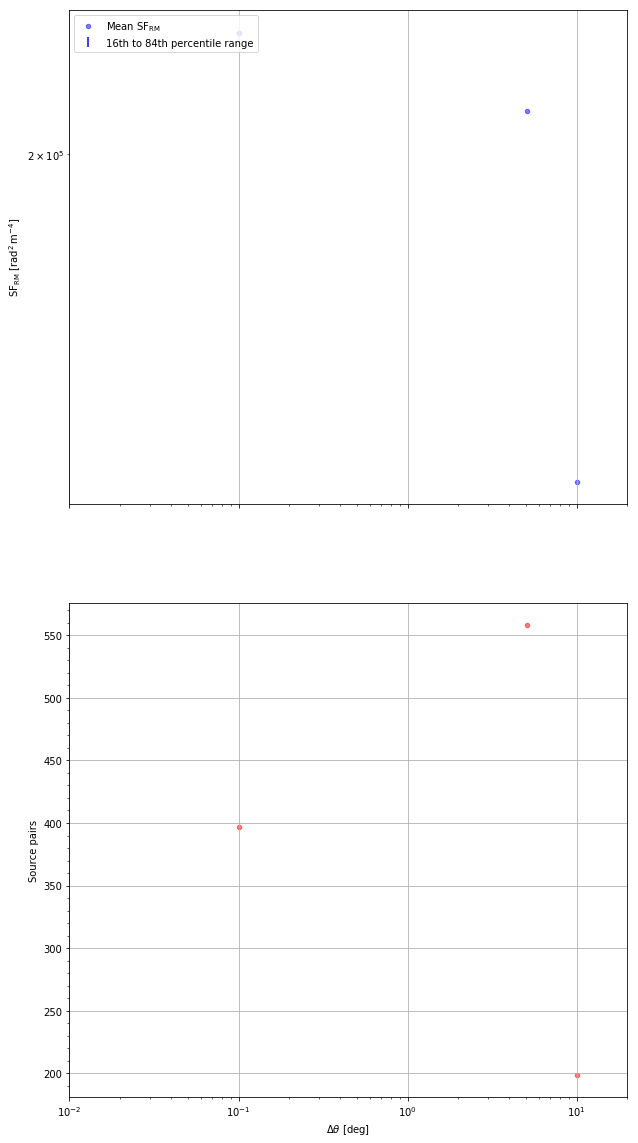

In [238]:
np.std(rm_sf[0])

121.76810111718545